# Field Analysis


In [1]:
%config InlineBackend.figure_format = 'retina' # Nicer plots

In [2]:
from math import pi

import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.constants import c, e, epsilon_0

from genesis import Genesis4
from genesis.version4.input import Write

h = scipy.constants.value("Planck constant in eV/Hz")
Z0 = pi * 119.916983  # V^2 / m

# Create field data

In [3]:
%%time
G = Genesis4("data/basic4/cu_hxr.in", verbose=True)
G.input.main.time.sample = 200
G.input.main.track.zstop = 40
G.input.main.namelists.append(Write(field="end"))
G.nproc = 0  # auto-select
output = G.run()

Configured to run in: /var/folders/vy/s8_hc3m10fddm6n_43cf_m8r0000gn/T/tmprcy0ux90
Setting use_mpi = True because nproc = 0
Running Genesis4 in /var/folders/vy/s8_hc3m10fddm6n_43cf_m8r0000gn/T/tmprcy0ux90
/Users/klauer/miniforge3/envs/lume-genesis/bin/mpirun -n 0 /Users/klauer/miniforge3/envs/lume-genesis/bin/genesis4 -l hxr.lat genesis4.in
---------------------------------------------
GENESIS - Version 4.6.6 has started...
Compile info: Compiled by runner at 2024-01-11 18:10:26 [UTC] from Git Commit ID: 
Starting Time: Tue May 21 16:16:51 2024

MPI-Comm Size: 12 nodes

Opened input file genesis4.in
Parsing lattice file hxr.lat ...
Setting up time window of 15.2233 microns with 552 sample points...
Generating input radiation field for HARM = 1 ...
Adding profile with label: beamcurrent
Adding profile with label: beamgamma
Generating input particle distribution...

Running Core Simulation...
Time-dependent run with 552 slices for a time window of 15.2233 microns
Initial analysis of elec

In [4]:
G.path

'/var/folders/vy/s8_hc3m10fddm6n_43cf_m8r0000gn/T/tmprcy0ux90'

<!-- lume-genesis detected Jupyter and will use HTML for rendering. -->

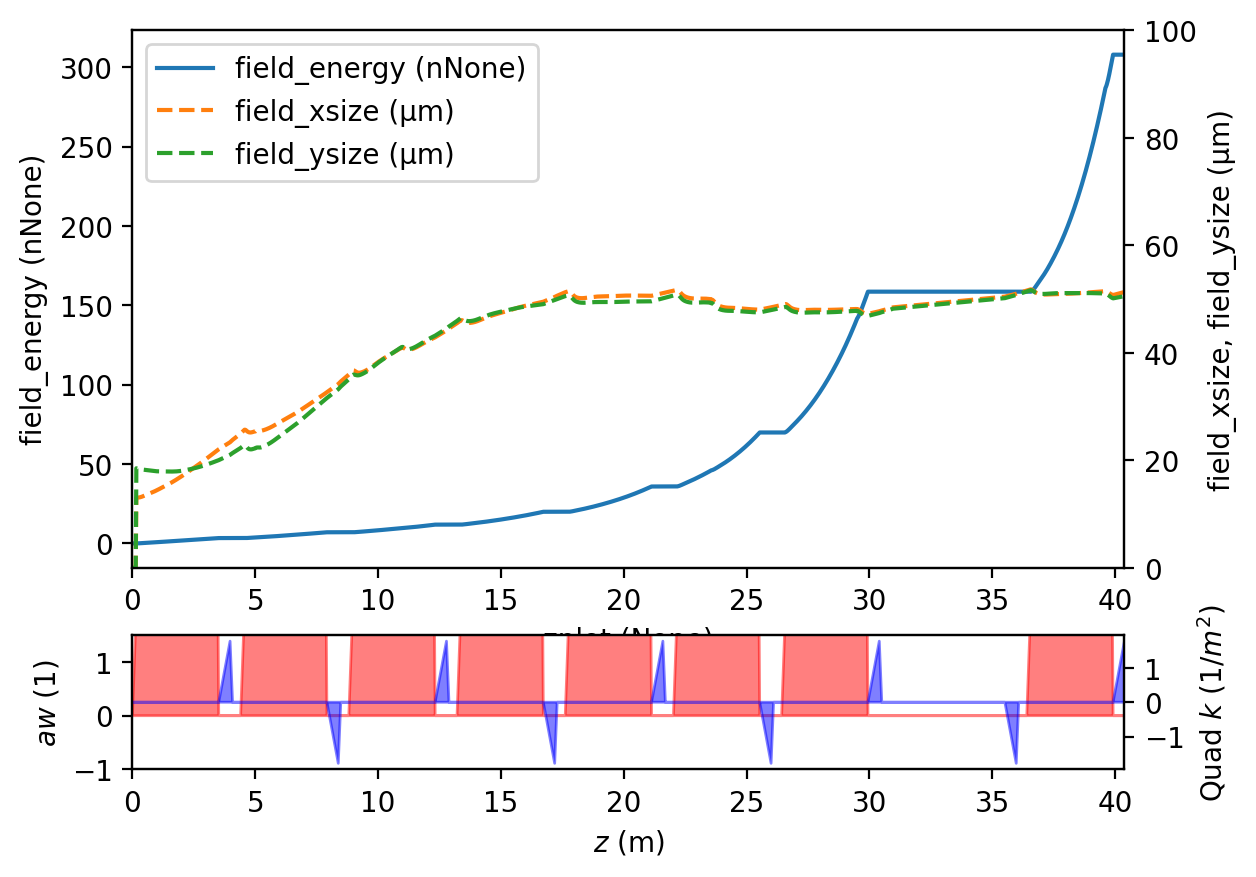

In [5]:
G.plot("field_energy", y2=["field_xsize", "field_ysize"], ylim2=[0, 100e-6])

In [6]:
G.verbose = True
output.load_fields()

['end']

# 3D Field data

The full field data is stored as a 3D array of complex numbers `DFL` in units of `sqrt(W)`.

The relation of this and the electric field `E` in V/m is:
```
E = DFL * sqrt(2*Z0) / Δ
```
Where `Z0 = π * 119.9169832 V^2/W` exactly and `Δ` is the grid spacing. 

In [7]:
DFL = output.field["end"].dfl  # sqrt(W)

DFL.dtype, DFL.shape

(dtype('complex128'), (101, 101, 552))

In [8]:
param = output.field["end"].param

param

FieldFileParams(
  gridpoints=101,
  gridsize=2e-06,
  refposition=0.0,
  wavelength=1.3789244869952112e-10,
  slicecount=552,
  slicespacing=2.7578489739904225e-08,
)

Gather some convenient variables and arrays:

In [9]:
Ns = param.slicecount
ds = param.slicespacing
λ0 = param.wavelength
f0 = c / λ0
dt = ds / c
Δ = param.gridsize

s = np.arange(0, Ns) * ds
t = -s / c

# Field power

The power array sums over the x and y components of the absolute square of the field data.

In [10]:
power0 = G.output["field_power"][-1, :]  # W

In [11]:
power1 = np.sum(np.sum(np.abs(DFL) ** 2, axis=0), axis=0)  # W

These are the same:

In [12]:
np.allclose(power0, power1)

True

Text(0, 0.5, 'power (GW)')

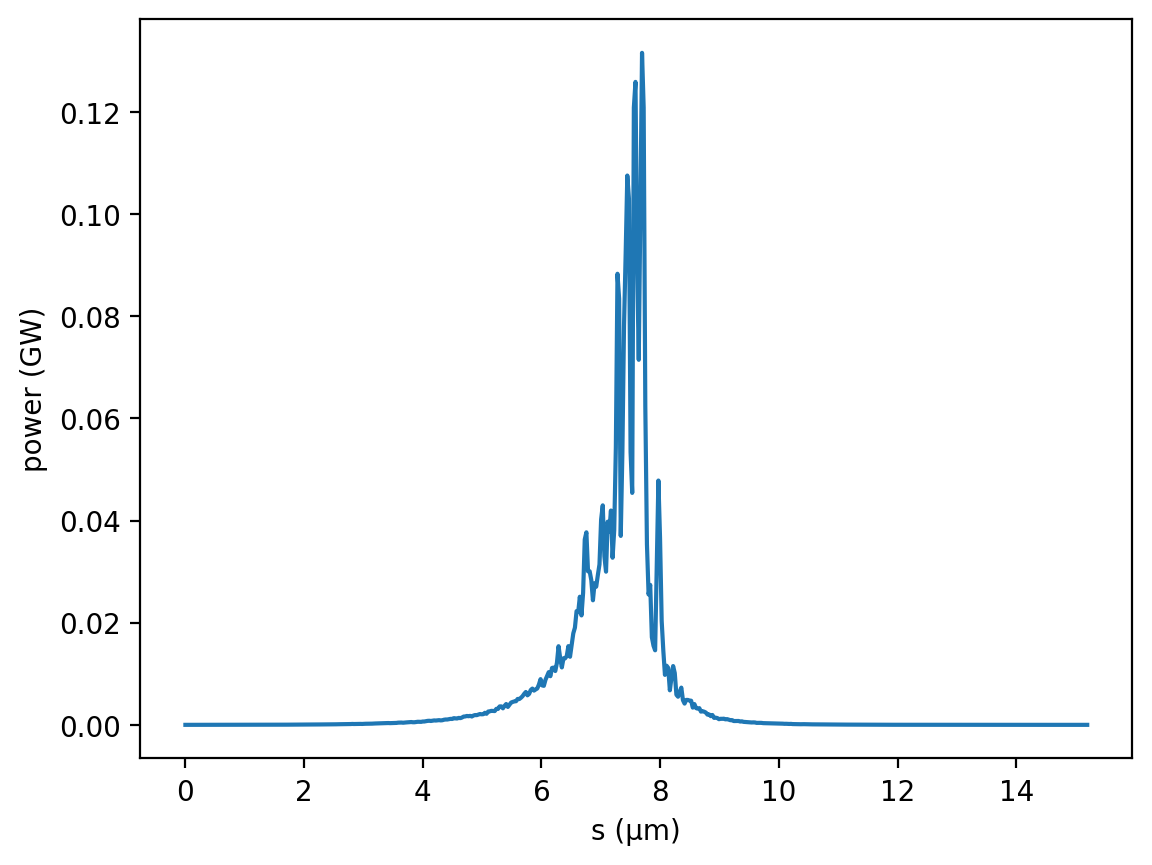

In [13]:
fig, ax = plt.subplots()
ax.plot(s * 1e6, power0 / 1e9)
ax.set_xlabel("s (µm)")
ax.set_ylabel("power (GW)")

# Field energy

The total field energy is the integral:

In [14]:
energy1 = np.trapz(power1, dx=dt)

energy1  # J

3.0801428069440024e-07

In [15]:
np.sum(power1) * dt  # J

3.0801428346362225e-07

# On-axis field intensity and phase

In [16]:
field_info = G.output.field_info
intensity0 = field_info.intensity_nearfield[-1, :]  # W/m^2
phase0 = field_info.phase_nearfield[-1, :]  # radian

In [17]:
icenter = param.gridpoints // 2
field1 = DFL[icenter, icenter, :]  # sqrt(W)
phase1 = np.angle(field1)  # radian

intensity1 = np.abs(field1**2) / Δ**2  # W/m^2

These are the same:

In [18]:
np.allclose(intensity0, intensity1)

True

In [19]:
np.allclose(phase0, phase1)

True

Text(0, 0.5, 'intensity (W/m$^2$)')

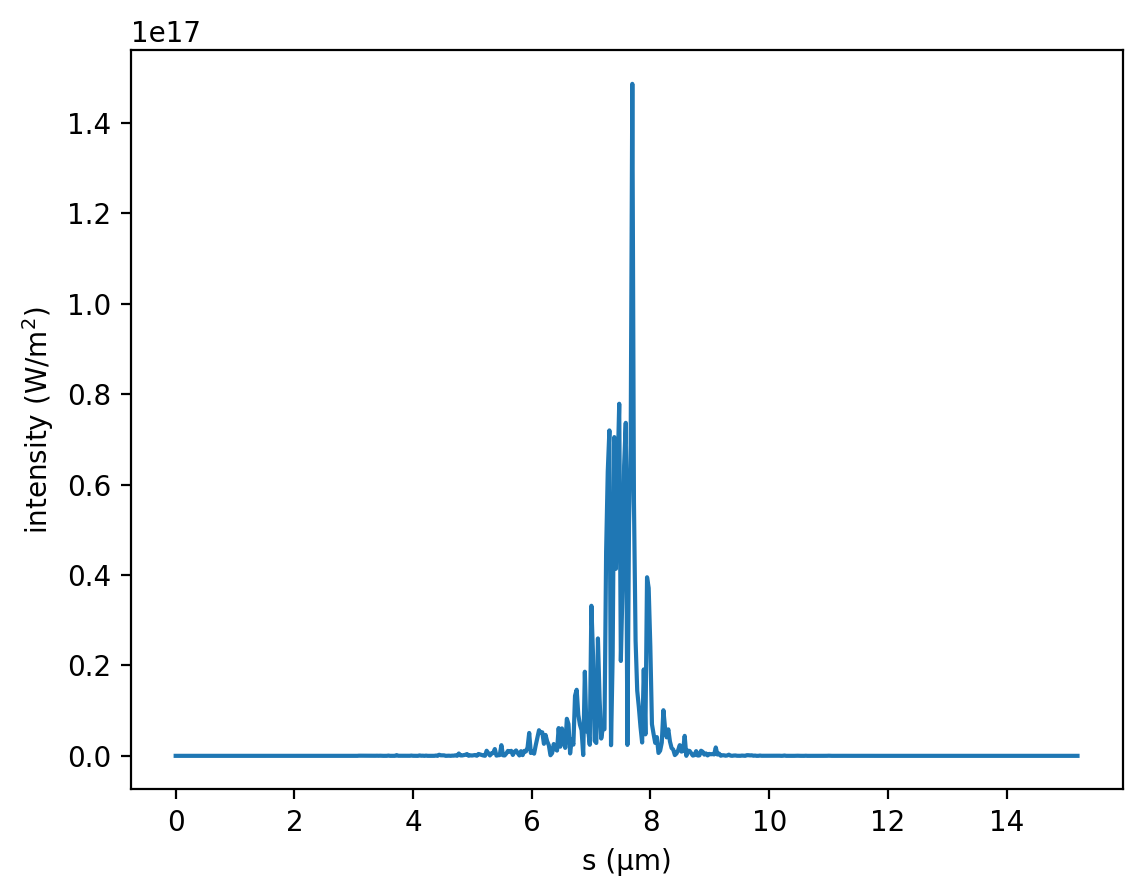

In [20]:
fig, ax = plt.subplots()
ax.plot(s * 1e6, intensity0)
ax.set_xlabel("s (µm)")
ax.set_ylabel(r"intensity (W/m$^2$)")

The same field can be reconstructed from these arrays

In [21]:
field0 = np.sqrt(intensity0) * np.exp(1j * phase0) * Δ  # sqrt(W)

These are the same:

In [22]:
np.allclose(field0, field1)

True

# Spectral fluence

The spectrum calculation takes some care with the FFT and units.

In [23]:
def spectrum_from_field(field, dt=1):
    """
    Calculates the spectrum (fourier transformed field)
    from a complex field array with spacing dt.

    Parameters
    ----------
    field: nd.array of shape (n,)
        Complex field

    dt: float
        Spacing of the field data in some units (e.g. 's')

    Returns
    -------
    freqs: nd.array of shape (n,)
        Frequencies in reciprocal space with inverse units (e.g. 'Hz = 1/s')

    spectrum: nd.array of shape (n,)
        The fourier transformed field

    """
    assert len(field.shape) == 1, "Only 1D arrays are currently supported"
    spectrum = np.fft.fftshift(np.fft.fft(field)) * dt

    ns = len(field)
    freqs = np.fft.fftshift(np.fft.fftfreq(ns, dt))

    return freqs, spectrum

In [24]:
freqs, spectrum = spectrum_from_field(field0, dt)

# Frequency spacing
# df = np.diff(freqs)[0] # Hz

df = 1 / (dt * len(field0))

df

19692966660160.316

Check Plancherel theorem

In [25]:
np.sum(np.abs(field0) ** 2) * dt  # J

5.731896826553546e-10

In [26]:
np.sum(np.abs(spectrum) ** 2) * df  # J

5.731896826553546e-10

Text(0, 0.5, 'spectral fluence (J/m$^2$/eV)')

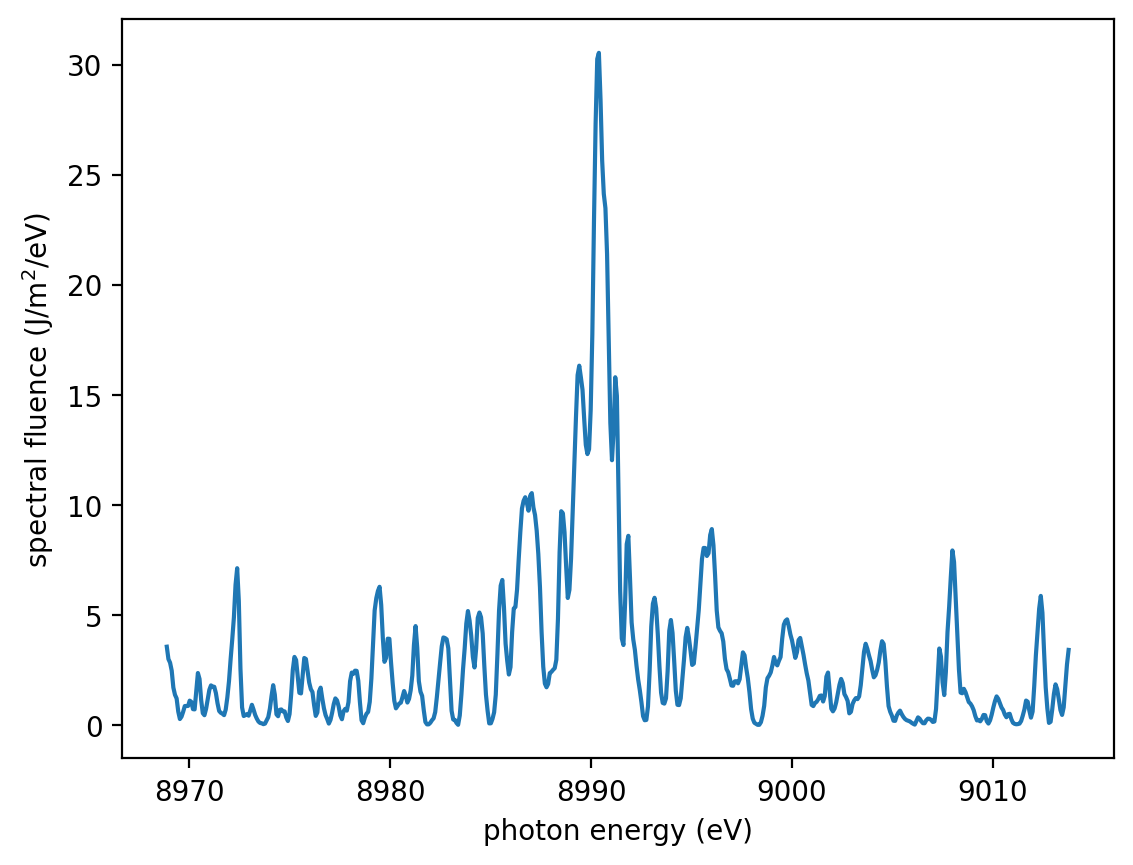

In [27]:
freqs, spectrum = spectrum_from_field(field0, dt)

fig, ax = plt.subplots()

photon_energies = h * (freqs + f0)  # eV
spectral_fluence = np.abs(spectrum**2) / Δ**2 / h  # J/m^2/eV

ax.plot(photon_energies, spectral_fluence)
ax.set_xlabel("photon energy (eV)")
ax.set_ylabel(r"spectral fluence (J/m$^2$/eV)")

Text(0, 0.5, 'spectral intensity (photons/mm$^2$/eV)')

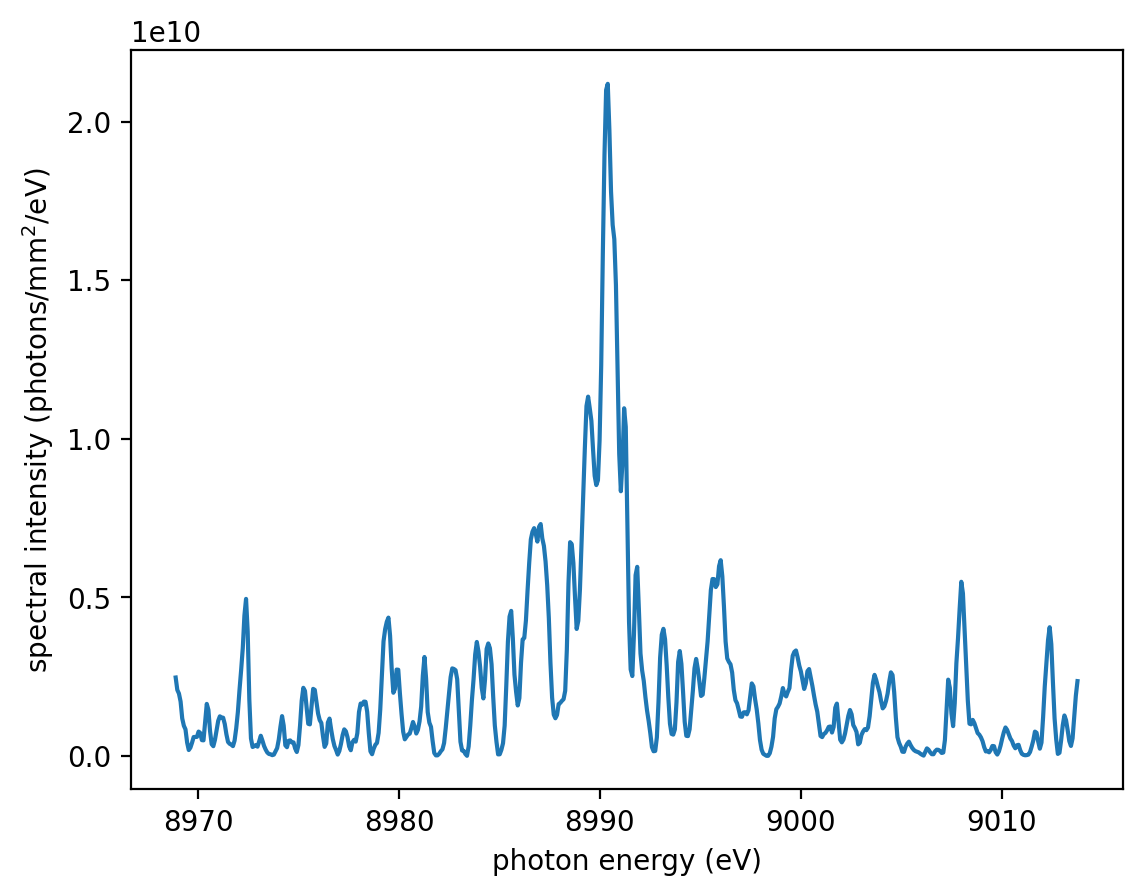

In [28]:
fig, ax = plt.subplots()
J_per_photon = h * (freqs + f0) * e  # note h is in eV/Hz
ax.plot(photon_energies, spectral_fluence / J_per_photon * 1e-6)
ax.set_xlabel("photon energy (eV)")
ax.set_ylabel(r"spectral intensity (photons/mm$^2$/eV)")

# 3D FFT

WORK IN PROGRESS

In [29]:
field3d = DFL * np.sqrt(2 * Z0) / Δ  # Electric field
# field3d = np.pad(field3d, 100, constant_values = 0) #Pad
nx, ny, nz = field3d.shape
dx, dy, dz = Δ, Δ, ds
nx, ny, nz, dx, dy, dz

# reciprocal spacings
dkx, dky, dkz = 1 / (nx * dx), 1 / (ny * dy), 1 / (nz * dz)

In [30]:
spectrum3d = np.fft.fftshift(np.fft.fftn(field3d)) * dx * dy * dz

In [31]:
# Check total energy integral
np.sum(np.abs(field3d) ** 2) * dx * dy * dz * epsilon_0 / 2

3.080142827822211e-07

In [32]:
np.sum(np.abs(spectrum3d) ** 2) * dkx * dky * dkz * epsilon_0 / 2

3.080142827822212e-07

In [33]:
kx = np.fft.fftshift(np.fft.fftfreq(nx, dx))
ky = np.fft.fftshift(np.fft.fftfreq(ny, dy))
kz = np.fft.fftshift(np.fft.fftfreq(nz, dz))

In [34]:
Kx, Ky, Kz = np.meshgrid(kx, ky, kz, indexing="ij")
kz0 = 2 * pi / λ0
Kz = Kz + kz0

K = np.sqrt(Kx**2 + Ky**2 + Kz**2)
k = K.flatten()
dEk = np.abs(spectrum3d.flatten()) ** 2 * dkx * dky * dkz * epsilon_0 / 2

In [35]:
np.sum(dEk)

3.0801428278222057e-07

Text(0, 0.5, 'spectral energy (µJ/eV)')

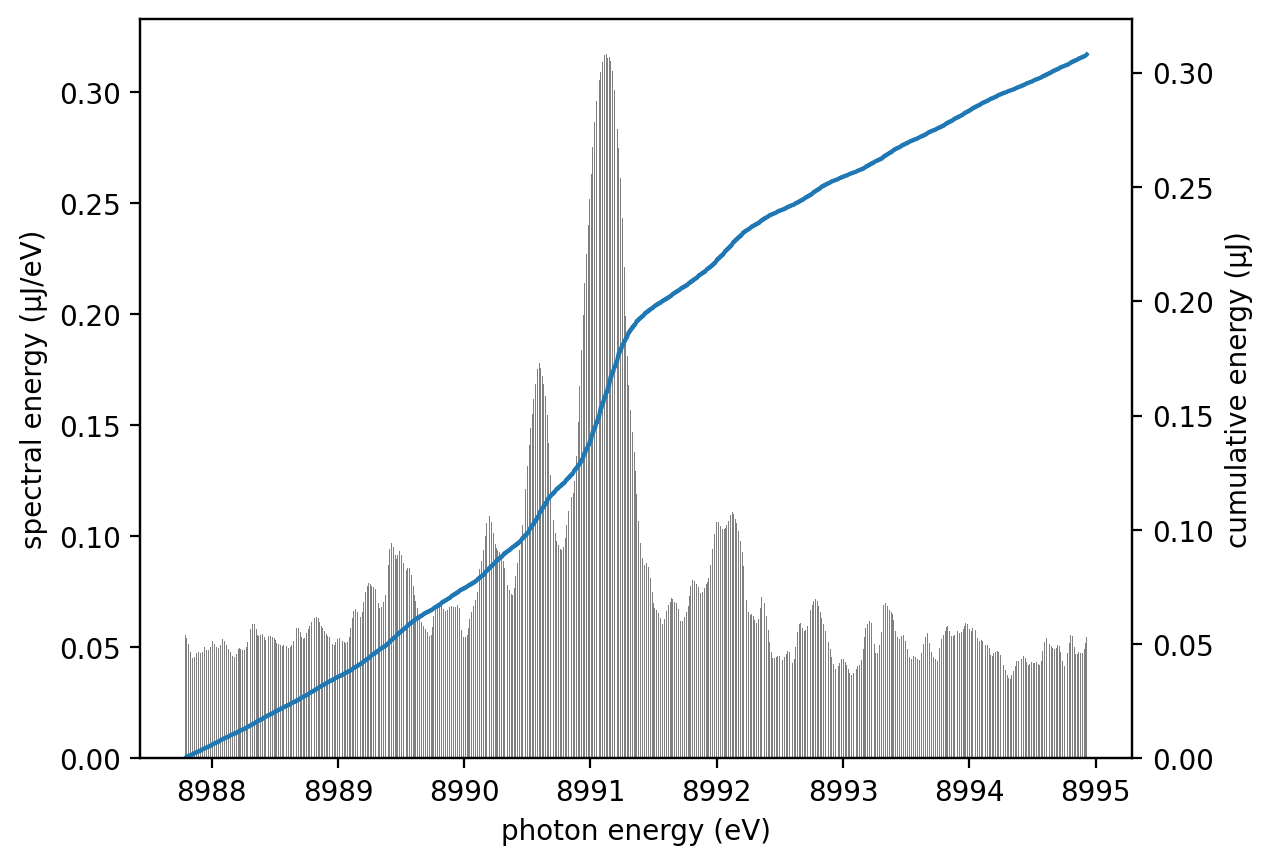

In [36]:
x = k * c * h / (2 * pi)  # eV
w = dEk
bins = 1000

hist, bin_edges = np.histogram(x, bins=bins, weights=w)
hist_x = bin_edges[:-1] + np.diff(bin_edges) / 2
hist_width = np.diff(bin_edges)

hist_y = hist / hist_width
# hist_y, hist_f, hist_prefix = nice_array(hist/hist_width)

fig, ax = plt.subplots()
ax.bar(hist_x, hist_y * 1e6, hist_width, color="gray")

ax2 = ax.twinx()
ax2.plot(hist_x, np.cumsum(hist) * 1e6)
ax2.set_ylabel("cumulative energy (µJ)")
ax2.set_ylim(0, None)

ax.set_xlabel("photon energy (eV)")
ax.set_ylabel("spectral energy (µJ/eV)")

# Field data formats

Genesis4 writes a custom field format. LUME-Genesis provides a reader for this, as well as a conversion tool to write in the [openPMD-wavefront standard](https://github.com/openPMD/openPMD-standard/blob/upcoming-2.0.0/EXT_Wavefront.md).

## Read Field h5

In [37]:
G.output.load_fields()

['end']

In [38]:
end_field = G.output.fields["end"]
DFL = end_field.dfl
PARAM = end_field.param

In [39]:
DFL.shape, DFL.dtype, PARAM

((101, 101, 552),
 dtype('complex128'),
 FieldFileParams(
   gridpoints=101,
   gridsize=2e-06,
   refposition=0.0,
   wavelength=1.3789244869952112e-10,
   slicecount=552,
   slicespacing=2.7578489739904225e-08,
 ))

## Write Wavefront in openPMD-wavefront

In [40]:
end_field.write_openpmd_wavefront("genesis4_wavefront.h5", verbose=True)

Writing wavefront (dfl data) to file genesis4_wavefront.h5


In [41]:
# Read back
import h5py

with h5py.File("genesis4_wavefront.h5", "r") as h5:
    print(list(h5["data"]["000000"]["meshes"]))

    g = h5["data/000000/meshes/electricField"]
    print(dict(g.attrs))

    # Get
    E2 = h5["data/000000/meshes/electricField/x"][:]

['electricField']
{'axisLabels': array(['x', 'y', 'z'], dtype=object), 'geometry': 'cartesian', 'gridGlobalOffset': array([-1.00000000e-04, -1.00000000e-04, -7.61166317e-06]), 'gridSpacing': array([2.00000000e-06, 2.00000000e-06, 2.75784897e-08]), 'gridUnitDimension': array([[1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0]]), 'gridUnitSI': array([1., 1., 1.]), 'photonEnergy': 8991.3696944618, 'photonEnergyUnitDimension': array([ 2,  1, -2,  0,  0,  0,  0]), 'photonEnergyUnitSI': 1.602176634e-19, 'timeOffset': 0.0, 'unitDimension': array([ 1,  1, -3, -1,  0,  0,  0])}


In [42]:
# Data is the same
np.allclose(E2, DFL)

True

# Plot

Simple plot

In [43]:
# Sum over y and compute the absolute square
dat2 = np.sum(np.abs(DFL) ** 2, axis=1)

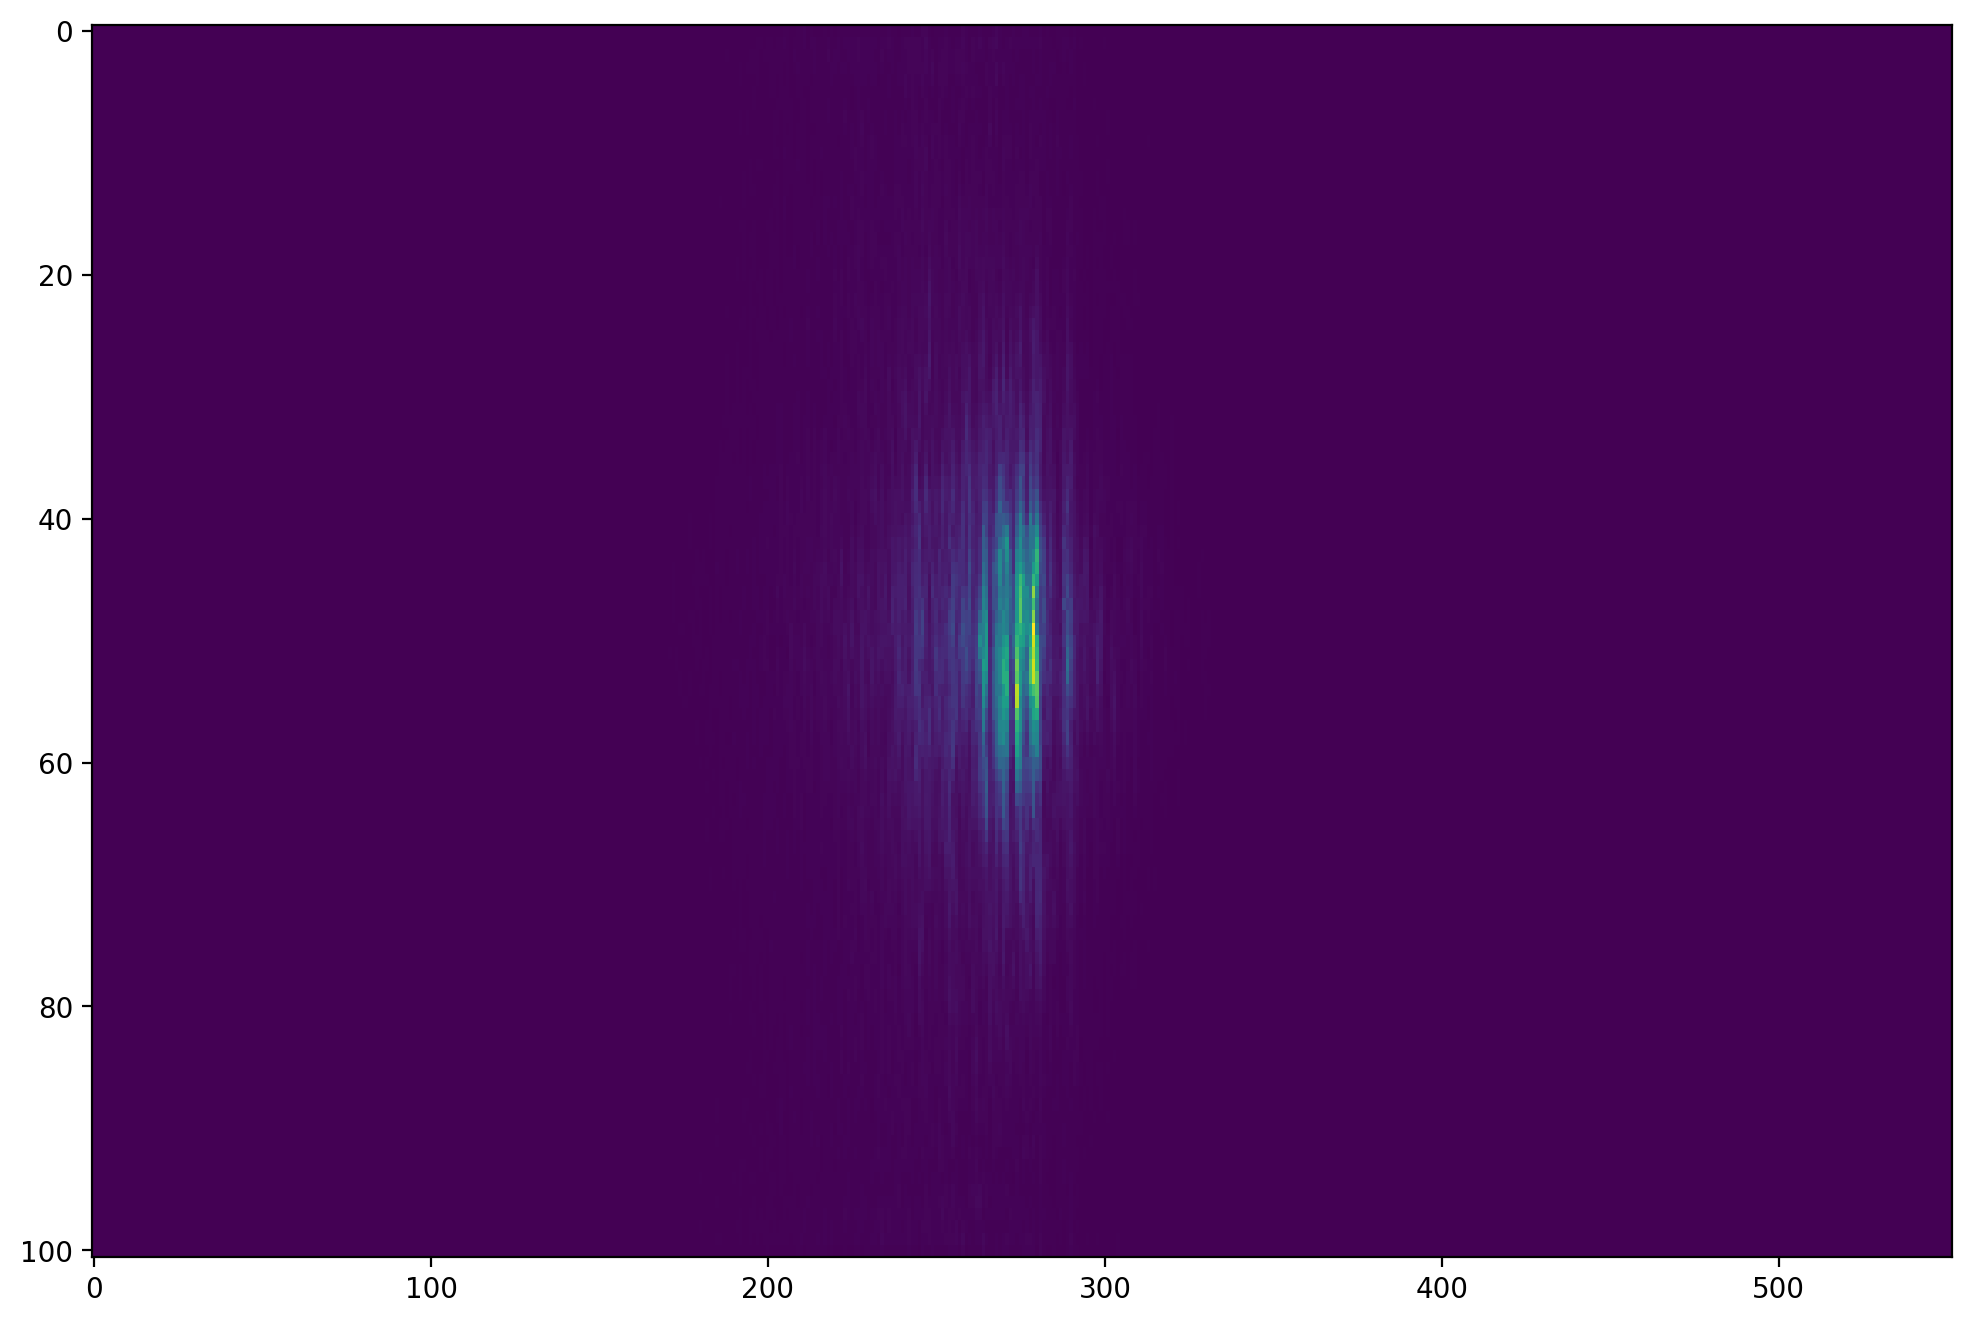

In [44]:
# Plot the center
plt.figure(figsize=(12, 8))
plt.imshow(dat2[::, :], aspect="auto")
# plt.axis('off');plt.savefig('../../assets/field.png', bbox_inches='tight')

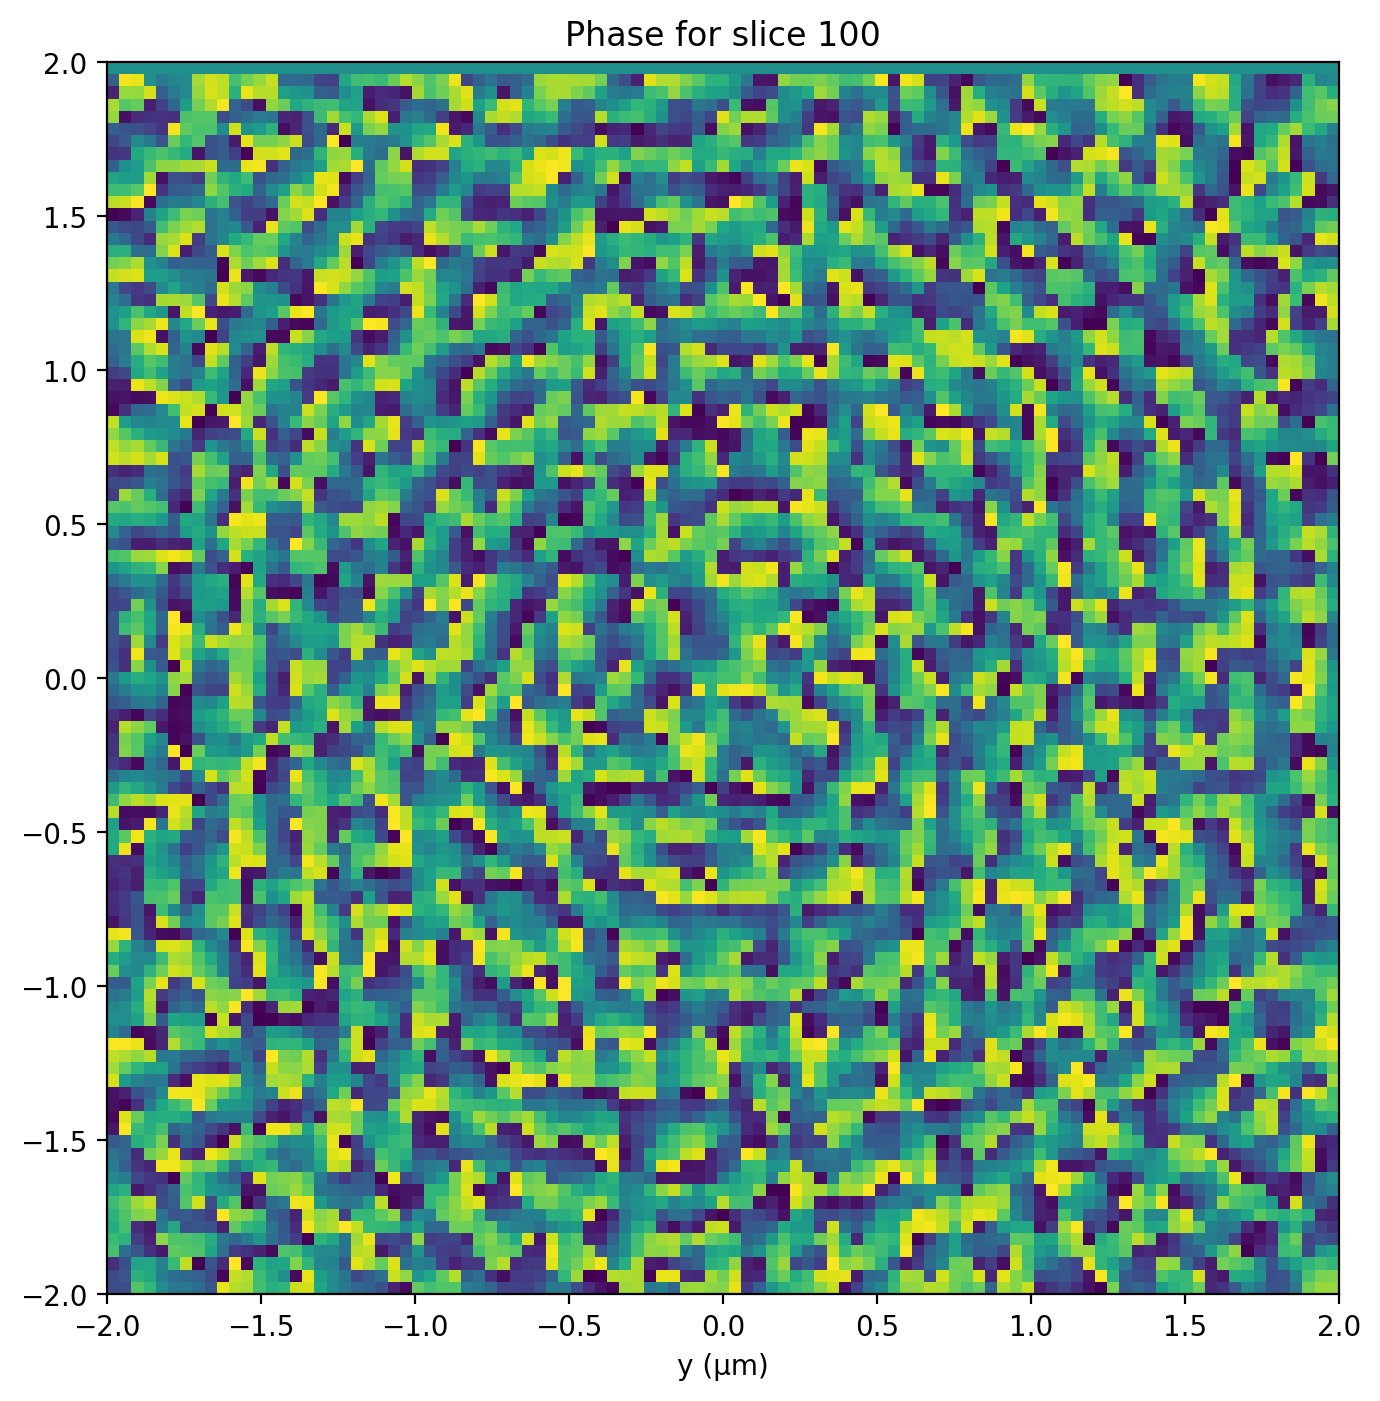

In [45]:
def plot_slice(i=0):
    dat = np.angle(DFL[:, :, i])
    dx = PARAM.gridsize * 1e6

    plt.figure(figsize=(8, 8))
    plt.xlabel("x (µm)")
    plt.xlabel("y (µm)")
    plt.title(f"Phase for slice {i}")
    plt.imshow(dat.T, origin="lower", extent=[-dx, dx, -dx, dx])


plot_slice(i=100)

# Interactive 

In [46]:
try:
    from ipywidgets import interact
except ImportError:
    pass
else:
    interact(plot_slice, i=(0, len(DFL[0, 0, :]) - 1, 1))

# Cleanup 

In [47]:
import os

os.remove("genesis4_wavefront.h5")